The only purpose of this notebook is to generate a submission.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
data_eng_fpath = '../data/intermediate/' if LOCAL else '../input/data-engineering/'
out_fpath = '../data/intermediate/' if LOCAL else ''
model_fpath = '../results/models/' if LOCAL else ''
selected_feats_fpath = '../data/intermediate/' if LOCAL else '../input/lightgbm-feature-selection/'

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
from datetime import datetime
import pickle

import lightgbm as lgb
import pandas as pd
import numpy as np

SEED = np.random.randint(1000)
SEED

743

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


from sklearn.svm import SVC, OneClassSVM

from imblearn.over_sampling import RandomOverSampler, SMOTENC

## Load Training DataFrame
* Here I instead load the one-hot encoded file

In [5]:
X = pd.read_pickle(f"{data_eng_fpath}X_enc.pkl")
y = pd.read_pickle(f"{data_eng_fpath}y.pkl")
X.shape, y.shape

((862, 2112), (862,))

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 861
Columns: 2112 entries, 445 to ppi_min_corr_2944
dtypes: float64(135), int64(25), uint8(1952)
memory usage: 2.7 MB


## Load Competition Data
* Note that data engineering pipeline drops labels, so we'll need this

In [7]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

In [8]:
X_kaggle = pd.read_pickle(f"{data_eng_fpath}X_kaggle_enc.pkl")

## Scale Numeric Data

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = X.select_dtypes(include=numerics).columns

In [10]:
# # Scale numeric columns in training and kaggle data
# scaler = StandardScaler()
# X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
# X_kaggle[numeric_cols] = scaler.fit_transform(X_kaggle[numeric_cols])

## Feature Selection

In [11]:
with open(f'{selected_feats_fpath}important_feats.pkl', 'rb') as handle:
    important_feats = pickle.load(handle)
important_feats = X.columns
X = X[important_feats]

## Split Data
* Because some classes literally have one training instance, first I duplicate those values so they can appear in test data (best we can do tbh)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 861
Columns: 2112 entries, 445 to ppi_min_corr_2944
dtypes: float64(135), int64(25), uint8(1952)
memory usage: 2.7 MB


In [13]:
ros = RandomOverSampler(sampling_strategy={i : 5 for i in range(12, 15)})
X_upsampled, y_upsampled = ros.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_upsampled, y_upsampled, test_size=0.33, stratify=y_upsampled)

X_train.shape, X_test.shape

((584, 2112), (289, 2112))

### Logistic Regression

In [15]:
logistic_model = LogisticRegression(C=1.15, penalty='l1', solver='liblinear', n_jobs=-1)
logistic_model.fit(X_train, y_train)
y_pred = pd.Series(logistic_model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.85       121
           1       0.59      0.67      0.63        63
           2       0.57      0.35      0.43        23
           3       0.72      0.68      0.70        19
           4       0.33      0.21      0.26        14
           5       0.88      0.50      0.64        14
           6       0.80      0.67      0.73        12
           7       0.80      0.67      0.73         6
           8       1.00      0.50      0.67         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2

    accuracy                           0.71       289
   macro avg       0.63      0.51      0.55       289
weighted avg       0.70   

In [36]:
coeffs = pd.DataFrame(zip(X_train.columns, np.transpose(logistic_model.coef_.tolist()[0])),
                      columns=['features', 'coef'])
coeffs.sort_values('coef')

,features,coef
315,80_Yes,-2.661544
339,92_Yes,-1.497376
325,85_Yes,-1.227718
258,51_Yes,-0.945128
333,89_Yes,-0.942694
...,...,...
19,ppi_all_pct_0,2.611914
313,79_Yes,3.091759
286,65_Yes,3.373374
274,59_Yes,4.566808


### SVM

In [31]:
params = {
    'C': 0.233,
    'kernel': 'linear',
    'probability' : True,
}
svm_model = SVC(**params)
svm_model.fit(X_train, y_train)
y_pred = pd.Series(svm_model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       121
           1       0.55      0.71      0.62        63
           2       0.69      0.39      0.50        23
           3       0.61      0.58      0.59        19
           4       0.75      0.21      0.33        14
           5       0.75      0.43      0.55        14
           6       0.56      0.42      0.48        12
           7       0.67      0.67      0.67         6
           8       1.00      0.33      0.50         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2

    accuracy                           0.69       289
   macro avg       0.62      0.48      0.52       289
weighted avg       0.69   

## kNN

In [33]:
params = {
    'n_neighbors' : 8,
    'weights' : 'distance'
}
knn_model = KNeighborsClassifier(**params)
knn_model.fit(X_train, y_train)
y_pred = pd.Series(knn_model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68       121
           1       0.39      0.35      0.37        63
           2       0.31      0.22      0.26        23
           3       0.14      0.05      0.08        19
           4       0.10      0.07      0.08        14
           5       0.40      0.29      0.33        14
           6       0.50      0.17      0.25        12
           7       1.00      0.17      0.29         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2

    accuracy                           0.50       289
   macro avg       0.41      0.34      0.34       289
weighted avg       0.44   

## GaussianNB

In [19]:
params = {
}
nb_model = GaussianNB(**params)
nb_model.fit(X_train, y_train)
y_pred = pd.Series(nb_model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       121
           1       0.67      0.57      0.62        63
           2       0.52      0.52      0.52        23
           3       0.47      0.42      0.44        19
           4       0.41      0.64      0.50        14
           5       0.32      0.50      0.39        14
           6       0.31      0.75      0.44        12
           7       0.50      0.50      0.50         6
           8       0.25      0.17      0.20         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.50      1.00      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2

    accuracy                           0.62       289
   macro avg       0.45      0.52      0.47       289
weighted avg       0.66   

# Failure analysis
* Analyze which classes are failing

In [20]:
models = {
    'logistic_model' : logistic_model,
    'svm_model' : svm_model,
    'knn_model' : knn_model,
    'nb_model' : nb_model
}
model_preds = {}
for name, model in models.items():
    model_preds[name] = model.predict(X_test).ravel()
model_preds['true_label'] = y_test.ravel()

In [21]:
fails = pd.DataFrame(model_preds)
fails.head()

,logistic_model,svm_model,knn_model,nb_model,true_label
0,1,1,0,3,1
1,0,0,0,0,0
2,0,0,0,5,0
3,0,0,1,10,11
4,0,1,2,0,0


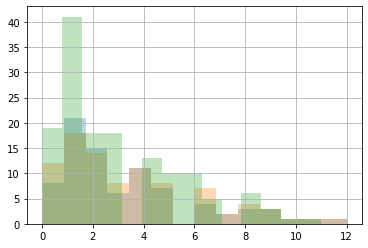

In [22]:
fails.loc[fails['logistic_model'] != fails['true_label'], 'true_label'].astype(int).hist(bins=14, alpha=0.3);
fails.loc[fails['svm_model'] != fails['true_label'], 'true_label'].astype(int).hist(bins=14, alpha=0.3);
fails.loc[fails['knn_model'] != fails['true_label'], 'true_label'].astype(int).hist(bins=14, alpha=0.3);

Majority of failures are in class 1. Also the second largest class! So the key to improving performance (specifically for this competition) is to increase the precision of class 1.

# One Class

In [23]:
y_one_train = y_train == 1  # encode a new label only for class 1
y_one_test = y_test == 1  # encode a new label only for class 1

In [24]:
one_class_svm_params = {
#     'kernel' : 'linear',
}
model_one = LogisticRegression(**one_class_svm_params)
model_one.fit(X_train, y_one_train)

LogisticRegression()

In [25]:
y_one_pred = pd.Series(model_one.predict(X_test))
print(classification_report(y_one_test, y_one_pred))

              precision    recall  f1-score   support

       False       0.85      0.95      0.89       226
        True       0.67      0.38      0.48        63

    accuracy                           0.82       289
   macro avg       0.76      0.66      0.69       289
weighted avg       0.81      0.82      0.80       289



Question is does this model perform better than the main models for predicting class 1.

In [26]:
models = {
    'logistic_model' : logistic_model,
    'svm_model' : svm_model,
#     'knn_model' : knn_model,
#     'nb_model' : nb_model,
    'one_class' : model_one,
}
model_preds = {}
for name, model in models.items():
    model_preds[name] = model.predict(X_test).ravel()
model_preds['true_label'] = y_test.ravel()
model_preds['one_class'] = model_preds['one_class'].astype(int)

In [27]:
fails = pd.DataFrame(model_preds)
class_one_fails = fails[fails['true_label'] == 1]

In [28]:
sum(class_one_fails['logistic_model'] != class_one_fails['true_label'])

21

In [29]:
sum(class_one_fails['one_class'] != class_one_fails['true_label'])

39